In [10]:
import cv2
from useful import *
from shape_classes import *
import bisect
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from fourier import *
from scipy.optimize import minimize_scalar

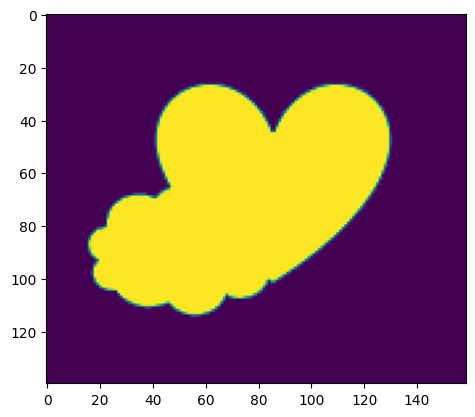

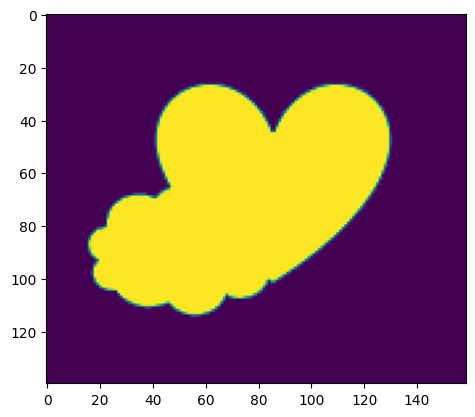

In [5]:
layout_name = "3.png"  
layout_path = os.path.join( os.getcwd(), 'images', layout_name)


layout_image = Image.open(layout_path)
image_array = np.array(layout_image)
# img = 255 - image_array[:,:,0]
img = image_array[:,:,0]
plt.imshow(img)
plt.show()
img_bin = my_preprocessing(img)
blobs_layout = connected_components(img_bin)

for blob in blobs_layout:
    blob_img = blob.image
    contour, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gx,gy = sample_polygon_uniformly(contour[0],200)
    contour_sampled = gx + gy*1.0j
    f_descriptors_layout = fourier_descriptors(contour_sampled)

layout_name = "3.png"  
layout_path = os.path.join( os.getcwd(), 'images', layout_name)


layout_image = Image.open(layout_path)
image_array = np.array(layout_image)
# img = 255 - image_array[:,:,0]
img = image_array[:,:,0]
plt.imshow(img)
plt.show()
img_bin = my_preprocessing(img)
blobs_layout = connected_components(img_bin)

for blob in blobs_layout:
    blob_img = blob.image
    contour, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gx,gy = sample_polygon_uniformly(contour[0],200)
    gx,gy = swap(gx,gy, 50)
    # contour_sampled = np.column_stack((gx, gy)).astype(np.int32)
    # print(np.size(contour_sampled))
    # print((contour_sampled))
    

    contour_sampled = gx + gy*1.0j
    # print(contour_sampled.size)
    # print((contour_sampled))
    f_descriptors_SEM = fourier_descriptors(contour_sampled)



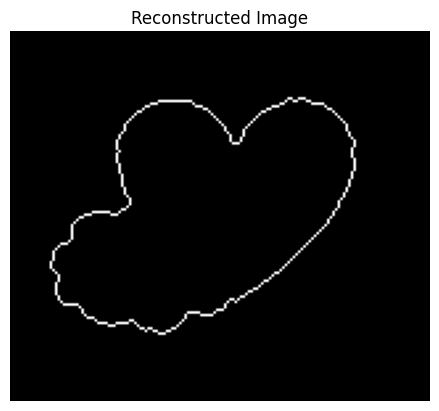

In [6]:
original_shape = img.shape

reconstructed_image = reconstruct_image(f_descriptors_SEM/(len(f_descriptors_SEM)/len(f_descriptors_SEM)), original_shape)

plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

In [7]:
f_descriptors_layout[0] = 0
f_descriptors_SEM[0] = 0

fl = f_descriptors_layout/ np.sqrt( np.sum( (np.abs(f_descriptors_layout))**2) )
fs = f_descriptors_SEM/ np.sqrt( np.sum( (np.abs(f_descriptors_SEM))**2) )
print(complex_l2(fl, fs) )

1.4153456768698836


In [11]:
# x = FourierDescriptor(fl, 1)
# y = FourierDescriptor(fs, 1)

# fla, flb = x.make_start_point_invariant()
# fsa, fsb = y.make_start_point_invariant()

fla, flb = make_start_point_invariant(fl)
fsa, fsb = make_start_point_invariant(fs)

print(complex_l2(fla, fsa) )
print(complex_l2(fla, fsb) )
print(complex_l2(flb, fsa) )
print(complex_l2(flb, fsb) )


1.9860320072689104
4.5141380347702134e-07
4.514138043947001e-07
1.9860320072689102


In [4]:
def make_start_point_invariant(G):
    phi = get_start_point_phase(G)
    Ga = shift_start_point_phase(G, phi)
    Gb = shift_start_point_phase(G, phi + np.pi)
    return Ga, Gb
    
def get_start_point_phase(G):
    mp = (len(G) - 1) // 2
    def fp(phi):
        sum_val = 0
        for m in range(1, mp + 1):
            Gm = G[(-m) % len(G)] * np.exp(-1j * m * phi)
            Gp = G[(m) % len(G)] * np.exp(1j * m * phi)
            sum_val += Gp.real * Gm.imag - Gp.imag * Gm.real
        return sum_val

    res = minimize_scalar(lambda phi: -fp(phi), bounds=(0, np.pi), method='bounded')
    return res.x

def shift_start_point_phase(G, phi):
    Gnew = G.copy()
    mp = (len(G) - 1) // 2
    
    for m in range(-mp, mp + 1):
        if m != 0:
            k = (m) % len(G)
            Gnew[k] *= np.exp(1j * m * phi)
    return Gnew

def complex_l2(f1,f2):
    a = f1 -f2
    return np.sqrt(np.sum((a.real)**2 + (a.imag)**2))

def swap(a,b,x):
    temp = a[:x]

    a = np.concatenate((a[x:], temp))

    temp = b[:x]
    b = np.concatenate( (b[x:], temp))

    return a,b